In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
# Constants
h = 6.602e-34
hbar = h/(2*np.pi)
kB = 1.38e-23
eps_0 = 8.85e-12
c_0 = 299792458
e = 1.602e-19
m_e = 9.109e-31
a_0 = 0.53e-10
mu_B = e*hbar/(2*m_e)

In [3]:
#Internal basis vectors expressed in lab frame. SiV high symmetry axis is along z: <111>
x = np.array([-1,1,0])
x = x/np.linalg.norm(x)
y = np.array([-1,-1,2])
y = y/np.linalg.norm(y)
z = np.array([1,1,1])
z = z/np.linalg.norm(z)

#Rotation matrix to switch from internal to external lab frame
R_ext_int = np.vstack((x,y,z)).T
R_int_ext = np.linalg.inv(R_ext_int)

In [4]:
''' 
    States and operators:
    Orbitals ordering
    0: |e_gx>
    1: |e_gy>
    2: |e_ux>
    3: |e_uy>

    Therefore orbital plus operator L_p_x = |e_g_y><e_g_x| ... 
    Due to D3d symmetry only L_z is non-zero. L_x and L_y vanish.

    Define spin up |🠕> as lower energy state.
'''
N_orbs = 4 
egx = basis(N_orbs, 0)
egy = basis(N_orbs, 1)
eux = basis(N_orbs, 2)
euy = basis(N_orbs, 3)

N_spins = 2
su = basis(N_spins,0)
sd = basis(N_spins,1)
N = N_orbs*N_spins

labels = [
    r'$|e_{g_+}, \uparrow\rangle$',
    r'$|e_{g_-}, \downarrow\rangle$',
    r'$|e_{g_+}, \downarrow\rangle$',
    r'$|e_{g_-}, \uparrow\rangle$',
    r'$|e_{u_+}, \uparrow\rangle$',
    r'$|e_{u_-}, \downarrow\rangle$',
    r'$|e_{u_+}, \downarrow\rangle$',
    r'$|e_{u_-}, \uparrow\rangle$',
    r'$\mathbb{1}$']
colors = [
    'k',
    'k',
    'r',
    'r',
    'b',
    'b',
    'y',
    'y',
    'r'
]
styles = [
    '--',
    '-.',
    '--',
    '-.',
    '--',
    '-.',
    '--',
    '-.',
    '-'
]

Orbital Hamiltonian is just given by the splitting between "gerade" and "ungerade" orbital manifold $E_{g}$ and $E_{u}$ which are split by $\hbar\omega_0 = 1.68eV$

In [5]:
'''System Dynamics:
Orbital part comprising Spin-Orbit, Jahn Teller, Zeeman and Strain couplin
'''
HOrb = Qobj(np.zeros((N_orbs, N_orbs)))
HOrb += 1.68*e/h*(eux*eux.dag()+euy*euy.dag())
HOrb = tensor(HOrb, qeye(N_spins))

Due to interaction of the electrons orbital angular momentum $\vec{L}$ with spin angular momentum $\vec{S}$, both two-fold orbital manifolds $E_{g}$ and $E_{u}$ split in energy by $H_{\mathrm{SO, (g,u)}} = \frac{\hbar}{4c^2m} \left( \vec{\nabla} V_{el} \times \vec{p}\right) \cdot \vec{S}/\hbar$. <br>
Since the gradient of the coulomb potential $\vec{\nabla} V_{el}$ is different for "gerade" and "ungerade" manifolds, the interaction energy $\lambda_{g,u} = H_{\mathrm{SO}} / \hbar$ is also different with $\lambda _g = 46$ GHz and $\lambda _u = 250$ GHz. <br>
The Spin-Orbit Hamiltonian can be written within orbital degrees of freedom
$
\begin{align}
H_\mathrm{SO} = \frac{\lambda_{g,u}}{2}\sigma^{g,u}_y S_z
\end{align}
$

In [6]:
#Spin-Orbit coupling
SO_g = 46e9
SO_e = 250e9
HSO = -SO_g/2*tensor(1j*egy*egx.dag() - 1j*egx*egy.dag(), su*su.dag() - sd*sd.dag()) 
HSO+= -SO_e/2*tensor(1j*euy*eux.dag() - 1j*eux*euy.dag(), su*su.dag() - sd*sd.dag()) 

In [7]:
#Static strain coupling
delta_g = 0
alpha_g = 0
beta_g = 0
HStr_g = (delta_g+alpha_g)*egx*egx.dag()
HStr_g += beta_g*egx*egy.dag()
HStr_g += beta_g*egy*egx.dag()
HStr_g += (delta_g-alpha_g)*egy*egy.dag()

delta_e = 0
alpha_e = 0
beta_e = 0
HStr_e = (delta_e+alpha_e)*eux*eux.dag()
HStr_e += beta_e*eux*euy.dag()
HStr_e += beta_e*euy*eux.dag()
HStr_e += (delta_e-alpha_e)*euy*euy.dag()

HStr = HStr_g + HStr_e
HStr = tensor(HStr, qeye(N_spins))

Up to this point the system Hamiltonian $H_\mathrm{Sys}$ consists of Orbital, Strain and Spin-Orbit interaction. Neglecting strain, this leads to the spin-orbit eigenstates $\ket{e^{g,u}_{\pm}} = \ket{e^{g,u}_{x}} \pm i \ket{e^{g,u}_{y}}$ <br><br>
$
\begin{align}
H_\mathrm{Sys}  
&= H_\mathrm{Orb} + H_\mathrm{SO} \\
= &\omega_0 \left( \left(\ket{e^u_x} \bra{e^u_x} + \ket{e^u_y} \bra{e^u_y}\right) \right) + \frac{\lambda_{g}}{2}\sigma^{g}_y S_z + \frac{\lambda_{u}}{2}\sigma^{u}_y S_z\\
= &\omega_0 \left( \sigma_{33} + \sigma_{44} \right) + \left[\frac{i\lambda_{g}}{2}\left( -\sigma_{12} + \sigma_{21}\right) + \frac{i\lambda_{u}}{2}\left( -\sigma_{34} + \sigma_{43}\right) \right] S_z\\
= &+\frac{\lambda^g}{2} \left( \ket{e^{g}_{+},\downarrow} \bra{e^{g}_{+},\downarrow} + \ket{e^{g}_{-},\uparrow} \bra{e^{g}_{+},\uparrow} \right)\\
&-\frac{\lambda^g}{2} \left(\ket{e^{g}_{+},\uparrow} \bra{e^{g}_{+},\uparrow} + \ket{e^{g}_{-},\downarrow} \bra{e^{g}_{+},\downarrow} \right)\\
& \left(\omega_0 + \frac{\lambda^u}{2} \right) \left(\ket{e^{u}_{+},\uparrow} \bra{e^{u}_{+},\uparrow} + \ket{e^{u}_{-},\downarrow} \bra{e^{u}_{+},\downarrow} \right)\\
&+\left(\omega_0 + -\frac{\lambda^u}{2} \right)\left(\ket{e^{u}_{+},\uparrow} \bra{e^{u}_{+},\uparrow} + \ket{e^{u}_{-},\downarrow} \bra{e^{u}_{+},\downarrow} \right)
\end{align}
$

In [15]:
HSys = HOrb+HSO

energies, eigenstates = HSys.eigenstates()
transitions = []
nu_A = energies[7]-energies[1]
nu_B = energies[7]-energies[3]
nu_C = energies[5]-energies[1]
nu_D = energies[5]-energies[3]


Interaction with photon and phonon baths at Temperatue T lead to relaxation (and also potentially dephasing which is neglected for the moment). These are implemented with collapse operators 
$
\begin{align}
c = \sqrt{\Gamma} \sigma_{ij} = \sqrt{{T_1}^{-1}} \sigma_{ij}
\end{align}
$
where $T_1$ is the corresponding orbital lifetime. Rates can be temperature-dependant through mean thermal occupation $n_\mathrm{th} = \left( \exp\left( \omega (k_\mathrm{B}T\right)^{-1}-1 \right)^{-1}$. For example the spontaneous phonon emission $\gamma_\mathrm{em}$ and absorption $\gamma_\mathrm{abs}$ fulfill 
$
\begin{align}
\gamma_\mathrm{em} &= \gamma_\mathrm{sp} \left(n_\mathrm{th} + 1\right) \\
\gamma_\mathrm{abs} &= \gamma_\mathrm{sp} n_\mathrm{th}
\end{align}
$
Source:
https://qutip.org/docs/latest/guide/dynamics/dynamics-master.html

In [16]:
# Environmental interactions
T = 5

tau_pht_C = 1.74e-9
tau_pht_D = 1/4*tau_pht_C
tau_pht_A = tau_pht_C
tau_pht_B = tau_pht_D

tau_phn_e = 200e-12
tau_phn_g = 40e-9

c_ops = []

# Neglect optical excitation from the environment --> only photon emission stimulated by photon bath @5K
# Assume all optical relaxations to be equally fast
c_ops.append(np.sqrt(1/(tau_pht_C))*tensor(egx*eux.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(1/(tau_pht_C))*tensor(egy*euy.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(1/(tau_pht_C))*tensor(egx*euy.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(1/(tau_pht_C))*tensor(egy*eux.dag(), qeye(N_spins)))

n_phn_g = 1/(np.exp(6.626e-34*46e9/(kB*T))-1)
egp = egx+1j*egy
egm = -1j*(egx-1j*egy)
c_ops.append(np.sqrt(1/(tau_phn_g))*tensor(egm*egp.dag(), sd*sd.dag())) 
c_ops.append(np.sqrt(1/(tau_phn_g)*n_phn_g/(n_phn_g+1))*tensor(egp*egm.dag(), sd*sd.dag())) 
c_ops.append(np.sqrt(1/(tau_phn_g))*tensor(egp*egm.dag(), su*su.dag())) 
c_ops.append(np.sqrt(1/(tau_phn_g)*n_phn_g/(n_phn_g+1))*tensor(egm*egp.dag(), su*su.dag())) 

Introducing an interaction with an external Laser field allows control of the orbital states, since the the orbital dipoles
$
\begin{align}
d_x  &= |d| \, (\ket{e^u_x}\bra{e^g_x} - \ket{e^u_y}\bra{e^g_y}) \\ 
d_y  &= |d| \, (-\ket{e^u_y}\bra{e^g_x} - \ket{e^u_x}\bra{e^g_y}) \\
d_z  &= |d| \, (\ket{e^u_x}\bra{e^g_x} + \ket{e^u_y}\bra{e^g_y}) ,
\end{align}
$
where $q$ is the elementary charge, couple to the electric field $\vec{E}$ (Source: Dissertation of Christian Hepp).<br><br><br>
The corresponding interaction Hamiltonian reads
$
\begin{align}
H_\mathrm{int}  &=  \vec{d}\cdot\vec{\epsilon} E\cos(\omega_\mathrm{L}t + \phi_\mathrm{L}) \\
                &= \left[ 
                    \epsilon_x \frac{\Omega_x}{2} \left( \left(\sigma_{31} +\sigma_{13} \right) - \left(\sigma_{42} + \sigma_{24} \right) \right) + 
                    \epsilon_y \frac{\Omega_y}{2} \left(-\left(\sigma_{41} +\sigma_{14} \right) - \left(\sigma_{32} +\sigma_{23} \right) \right) + 
                    \epsilon_z \frac{\Omega_z}{2} \left(\left(\sigma_{31} +\sigma_{13} \right) + \left(\sigma_{42} +\sigma_{24} \right) \right) 
                    \right] \cos(\omega_\mathrm{L}t + \phi_\mathrm{L}) \\
                &= \left[ 
                    \left(\epsilon_x \frac{\Omega_x}{2} + \epsilon_z \frac{\Omega_z}{2} \right) \left(\sigma_{31} +\sigma_{13} \right) + 
                    \left(-\epsilon_x \frac{\Omega_x}{2} + \epsilon_z \frac{\Omega_z}{2} \right) \left(\sigma_{42} +\sigma_{24} \right) +
                    \epsilon_y \frac{\Omega_y}{2} \left(-\left(\sigma_{41} +\sigma_{14} \right) - \left(\sigma_{32} +\sigma_{23} \right) \right)
                    \right] \cos(\omega_\mathrm{L}t + \phi_\mathrm{L})
\end{align}
$ 

where $\sigma_{ij} = \ket{i}\bra{j}$ with e.g. $\sigma_{31} = \ket{e^u_x}\bra{e^g_x}$, $\frac{\Omega_\alpha}{2} = (d_\alpha E_\alpha) /\hbar$ are the driving fields Rabi-frequency, $\epsilon_i$ are the polarizations of the driving field and $\omega_L$ is the lasers frequency.<br><br><br>
One can now perform a rotating frame transformation $R$ on the total Hamiltonian 
$
\begin{align}
H^R &= e^{-iR} \left(H_\mathrm{Sys} + H_\mathrm{int} \right)e^{iR} + i\hbar \frac{d R}{dt} \\
&= e^{-iR}  \left( \omega_0 \left( \sigma_{33} + \sigma_{44} \right) + \left[\frac{i\lambda_{g}}{2}\left( -\sigma_{12} + \sigma_{21}\right) + \frac{i\lambda_{u}}{2}\left( -\sigma_{34} + \sigma_{43}\right) \right] S_z  \right)e^{iR} + i\hbar \frac{d R}{dt}
\end{align}
$
such that the terms in the interaction Hamiltonian become time-independant
$
\begin{align}
e^{-iR} ( \cos\left(\omega_L t +\phi\right)\frac{\Omega_\alpha}{2} \underbrace{\left(\sigma_{ij} + \sigma_{ji}\right)}_{\sigma_x}) e^{iR} = \cos\left(\phi\right)\frac{\Omega_\alpha}{2} \sigma_x ,
\end{align}
$
as an example.<br>
Choosing $R = \omega_R t ((\sigma_{33} - \sigma_{11}) + (\sigma_{44} - \sigma_{22})))$ and using the identity 
$
\begin{align}
e^{-i \theta B} A e^{i \theta B} = \cos \theta A -i \sin \theta [B,A],
\end{align}
$
(only valid if $[B,[B,A]] = 0$) results in
$
\begin{align}
H^R = 
\end{align}
$
This introduces a rotating frame Hamiltonian


In [17]:
# Interaction (Laser) Hamiltonian is constructed within already performed rotating frame transformation and rotating wave approximation.
# In addition, Laser is assumed to be a coherent state and the corresponding photon bath is already traced out, leaving a pure color center Hamiltonian.
def rect_seq(start, width, num_pulses, delay, timeres=None):
    def rect(t, start, width):
        return np.heaviside(t-start,1)-np.heaviside(t-(start+width),1)

    def func(t, args=None):
        try:
            return seq[np.argmin(np.abs(t-t_seq))]
        except Exception as e:
            print(e)
            return 0

    if not timeres:
        timeres = width/100

    t_max = start + num_pulses*width+delay*num_pulses*(num_pulses+1)/2
    t_seq = np.arange(0, t_max, timeres)
    seq = np.zeros_like(t_seq)
    seq += rect(t_seq, start, width)
    for i in range(1,num_pulses):
        seq += rect(t_seq, start + width*i + delay*i*(i+1)/2, width)
        
    return t_seq, func

In [18]:
# Dipole operators, where factor 2 was introduced empirically
dx =  eux*egx.dag() - euy*egy.dag()
dy = -euy*egx.dag() - eux*egy.dag()
dz =  2*(eux*egx.dag() + euy*egy.dag())

# https://physics.stackexchange.com/questions/458654/rotating-wave-approximation-and-classical-rabi-oscillations-why-dont-the-fast
# https://physics.stackexchange.com/questions/222104/what-is-the-interaction-picture-or-rotating-frame-in-quantum-mechanics
# https://d-nb.info/1010923757/34

# External (lab) and internal (SiV) polarization of electric laser field, Rabi frequency as well as bare frequency
# Performing a rotating frame transformation on the system Hamiltonian
Omega_L1 = 0.1*1/tau_pht_C
nu_L1 = nu_C
eps_L1_ext = np.array([1,1,1])
eps_L1_ext = 1/np.linalg.norm(eps_L1_ext)*eps_L1_ext
eps_L1_int = np.squeeze(R_int_ext @ eps_L1_ext)
eps_L1_int = np.where(eps_L1_int<1e-14, 0, eps_L1_int)
H_L1 = Omega_L1/2*tensor(eps_L1_int[0]*(dx + dx.dag()), qeye(N_spins))
H_L1 += Omega_L1/2*tensor(eps_L1_int[1]*(dy + dy.dag()), qeye(N_spins))
H_L1 += Omega_L1/2*tensor(eps_L1_int[2]*(dz + dz.dag()), qeye(N_spins))

Omega_L2 = 0*1e9
nu_L2 = nu_C
eps_L2_ext = np.array([1,1,1])
eps_L2_ext = 1/np.linalg.norm(eps_L2_ext)*eps_L2_ext
eps_L2_int = np.squeeze(R_int_ext @ eps_L2_ext)
eps_L2_int = np.where(eps_L2_int<1e-14, 0, eps_L2_int)
H_L2 = Omega_L2/2*tensor(eps_L2_int[0]*(dx + dx.dag()), qeye(N_spins))
H_L2 += Omega_L2/2*tensor(eps_L2_int[1]*(dy + dy.dag()), qeye(N_spins))
H_L2 += Omega_L2/2*tensor(eps_L2_int[2]*(dz + dz.dag()), qeye(N_spins))

pulse_t_res = 1e-10
Hints = []
if Omega_L1:
    start_L1 = 0
    width_L1 = 80e-9
    num_pulses_L1 = 3
    delay_L1 = 5e-9
    t_seq_L1, pulse_seq_L1 = rect_seq(start_L1, width_L1, num_pulses_L1, delay_L1, pulse_t_res)

    HSys -= nu_L1*H_L1
    Hints = [[H_L1, pulse_seq_L1]]

if Omega_L2:
    start_L2 = 10e-9
    width_L2 = 5e-9
    num_pulses_L2 = 2
    delay_L2 = (width_L2+3)*1e-9
    t_seq_L2, pulse_seq_L2 = rect_seq(start_L2, width_L2, num_pulses_L2, delay_L2, pulse_t_res)
    
    if Omega_L1:
        HSys += (nu_L2-nu_L1)*tensor(egy*egy.dag()+egy*egy.dag(), qeye(N_spins))
        Hints.append([H_L2, pulse_seq_L2])
    else:
        HSys -= nu_L2*H_L2
        Hints = [[H_L2, pulse_seq_L2]]

H=[HSys]
for Hint in Hints:
    H.append(Hint)

H_L1

Quantum object: dims = [[4, 2], [4, 2]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[       0.               0.               0.               0.
  57471264.3678161        0.               0.               0.       ]
 [       0.               0.               0.               0.
         0.        57471264.3678161        0.               0.       ]
 [       0.               0.               0.               0.
         0.               0.        57471264.3678161        0.       ]
 [       0.               0.               0.               0.
         0.               0.               0.        57471264.3678161]
 [57471264.3678161        0.               0.               0.
         0.               0.               0.               0.       ]
 [       0.        57471264.3678161        0.               0.
         0.               0.               0.               0.       ]
 [       0.               0.        57471264.3678161        0.
         0.               0.         

In [12]:
# Environmental interactions
T = 5

tau_pht_C = 1.74e-9
tau_pht_D = 1/4*tau_pht_C
tau_pht_A = tau_pht_C
tau_pht_B = tau_pht_D

tau_phn_e = 200e-12
tau_phn_g = 40e-9

c_ops = []

# Neglect optical excitation from the environment --> only photon emission stimulated by photon bath @5K
# Assume all optical relaxations to be equally fast
c_ops.append(np.sqrt(1/(tau_pht_C*norm))*tensor(egx*eux.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(1/(tau_pht_C*norm))*tensor(egy*euy.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(1/(tau_pht_C*norm))*tensor(egx*euy.dag(), qeye(N_spins)))
c_ops.append(np.sqrt(1/(tau_pht_C*norm))*tensor(egy*eux.dag(), qeye(N_spins)))

n_phn_g = 1/(np.exp(6.626e-34*46e9/(kB*T))-1)
egp = egx+1j*egy
egm = -1j*(egx-1j*egy)
c_ops.append(np.sqrt(1/(tau_phn_g*norm))*tensor(egm*egp.dag(), sd*sd.dag())) 
c_ops.append(np.sqrt(1/(tau_phn_g*norm)*n_phn_g/(n_phn_g+1))*tensor(egp*egm.dag(), sd*sd.dag())) 
c_ops.append(np.sqrt(1/(tau_phn_g*norm))*tensor(egp*egm.dag(), su*su.dag())) 
c_ops.append(np.sqrt(1/(tau_phn_g*norm)*n_phn_g/(n_phn_g+1))*tensor(egm*egp.dag(), su*su.dag())) 

NameError: name 'norm' is not defined

In [12]:
e_ops = []
for eigenstate in eigenstates:
    e_ops.append(eigenstate*eigenstate.dag())
# e_ops.append(qeye(N_orbs*N_spins))

rho0 = tensor(Qobj(np.zeros((4,4))),Qobj(np.zeros((2,2))))
for energy, eigenstate  in zip(energies, eigenstates):
    rho0 += eigenstate*eigenstate.dag()*np.exp(-6.626e-34*(energy-energies[0])/(kB*T))
rho0 = rho0/rho0.tr()

t = t_seq_L1
options = Options()
options.nsteps = 1000
output = mesolve(H, rho0, t, c_ops=c_ops, e_ops=e_ops, options=options, args=None)


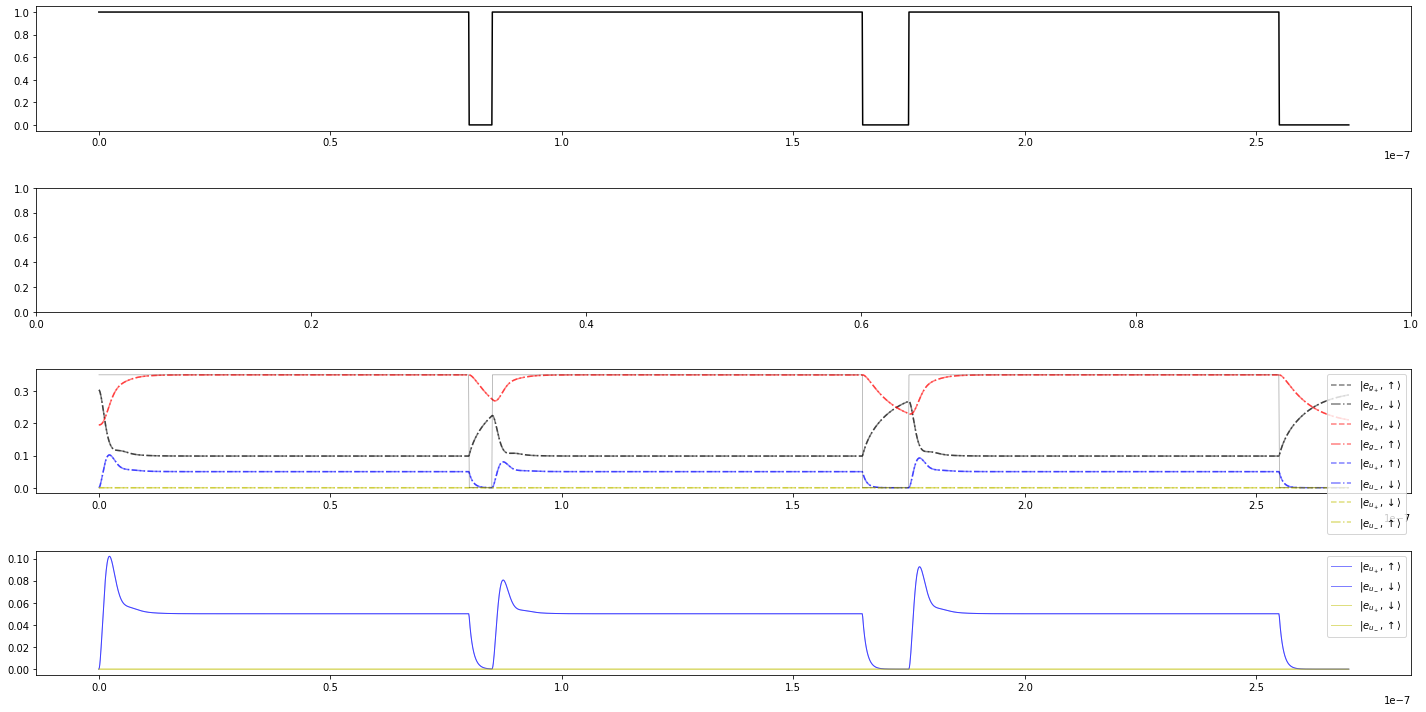

In [16]:
fig, axs = plt.subplots(4,1, figsize=(20,10))
fig.figsize = (20,10)

pulse_seq_L1_ = [pulse_seq_L1(t_) for t_ in t]
axs[0].plot(t, pulse_seq_L1_, '-k')

if Omega_L2:
    pulse_seq_L2_ = [pulse_seq_L2(t_) for t_ in t] 
    axs[1].plot(t, pulse_seq_L2_, '-k')

p_max = 0
for i, exp in enumerate(output.expect):
    p_max = max(exp) if max(exp)>p_max else p_max
    axs[2].plot(t, exp, label=labels[i], color=colors[i], linestyle=styles[i], alpha=0.5, linewidth=1.5)
    if i>3:
        axs[3].plot(t, exp, label=labels[i], color=colors[i], alpha=0.5, linewidth=1)

# Normalize pulse seq to maximal probability for better illustration
axs[2].plot(t, pulse_seq_L1_/max(pulse_seq_L1_)*p_max, '-k', alpha=0.5, linewidth=0.5)
axs[2].legend()
axs[3].legend()

plt.tight_layout()
plt.show()

In [ ]:
#Magnetic field unit vector
e_B_ext = np.array([[1],[1],[0]])
e_B_ext = e_B_ext/np.linalg.norm(e_B_ext)
Bs = np.linspace(0,7,100)

energies = np.zeros((N, len(Bs)))
for i, B in enumerate(Bs):

    #Zeeman coupling with quenching factor of f=0.1
    f = 0.1
    gamma_S = 2*mu_B/h
    gamma_L = mu_B/h
    
    B_ext = e_B_ext*B
    
    #Rotate into SiV internal coordinate system defined by applying (R_y*R_z)^-1
    B_x = np.squeeze(R_int_ext @ B_ext)[0]
    B_y = np.squeeze(R_int_ext @ B_ext)[1]
    B_z = np.squeeze(R_int_ext @ B_ext)[2]
        
    HZL = f*gamma_L*B_z*tensor((L_z_g+L_z_e),qeye(N_spins))    
    HZS = gamma_S*tensor(qeye(N_orbs),(B_x*S_x+B_y*S_y+B_z*S_z))
        
    energies[:,i] = (HOrb+HSO+HZL+HZS+HJT+HStr).eigenenergies()

In [ ]:
fig, axs = plt.subplots(3,1,True)
for i, energy in enumerate(energies):
    if i<4:
        axs[1].plot(Bs, energy, linestyle=styles[i], label=labels[i], color=colors[i])
    else:
        axs[0].plot(Bs, energy-1.68*e/h, linestyle=styles[i], label=labels[i], color=colors[i])
    
axs[0].legend()
axs[1].legend()
plt.show()

In [ ]:
#Fluorescence spectrum
tlist = np.linspace(0, 0.5e-6, 5000)
corr = correlation_2op_1t(H, None, tlist, c_ops, tensor(e_u_y*e_u_x.dag(),qeye(N_spins)), tensor(e_u_x*e_u_y.dag(),qeye(N_spins)))
wlist1, spec1 = spectrum_correlation_fft(tlist, corr)

fig, ax = plt.subplots(1, 1)
ax.plot(wlist1 / (2 * np.pi), spec1, 'b', lw=1, label='eseries method')
plt.show()


In [ ]:
from scipy.signal import bessel